In [1]:
# =========================================================
# Association Rule Mining Report - SQF 2012
# CRISP-DM: Data Preparation → Modelling → Evaluation
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
# -------------------------------------------------------------------
# 1. DATA PREPARATION
# -------------------------------------------------------------------

# Load cleaned SQF 2012 data

df = pd.read_csv("C:\\Users\\User\\Desktop\\DATA ANALYTICS\\DATA 475 - Advannced Data Analytics\\Assignment\\Final Project\\SQF_2012_cleaned.csv")

# Quick sanity check
print("Shape:", df.shape)
print(df.head())


Shape: (532911, 32)
   datestop  timestop  pct sex race   age  cs_objcs  cs_descr  cs_casng  \
0   1012012       115   40   M    B  20.0         0         0         1   
1   1012012       310   23   M    Q  18.0         0         0         0   
2   1012012      2000   81   M    B  19.0         0         1         0   
3   1022012      1245   81   M    B  37.0         0         1         0   
4   1042012      2220   66   M    Q  21.0         0         1         1   

   cs_lkout  ...  pf_hcuff  pf_pepsp  pf_other  precinct        stop_datetime  \
0         0  ...         0         0         0      40.0  2012-10-01 01:15:00   
1         0  ...         0         0         0      23.0  2012-10-01 03:10:00   
2         0  ...         0         0         0      81.0  2012-10-01 20:00:00   
3         0  ...         0         0         0      81.0  2012-10-02 12:45:00   
4         0  ...         0         0         0      66.0  2012-10-04 22:20:00   

   hour   weekday  time_of_day  stop_date 

In [4]:
# ---------- 1.1 Helper functions for feature engineering ----------

def map_sex(x):
    if pd.isna(x):
        return None
    x = str(x).strip().upper()
    if x == 'M':
        return 'Male'
    if x == 'F':
        return 'Female'
    return None  # treat anything else as missing/rare

def map_race(x):
    if pd.isna(x):
        return 'Race=Unknown'
    x = str(x).strip().upper()
    # Adjust mappings as needed for your coding scheme
    if x in ['B', 'BLACK']:
        return 'Race=Black'
    if x in ['P', 'HISPANIC']:
        return 'Race=Hispanic'
    if x in ['W', 'WHITE']:
        return 'Race=White'
    if x in ['A', 'ASIAN', 'Q', 'API']:
        return 'Race=Asian'
    if x in ['I']:
        return 'Race=NativeAmerican'
    return 'Race=Other'

def bin_age(a):
    try:
        a = float(a)
    except:
        return None
    if a < 18:
        return 'Age<18'
    elif a <= 24:
        return 'Age18-24'
    elif a <= 34:
        return 'Age25-34'
    else:
        return 'Age35+'

def parse_hour(t):
    """
    Expecting timestop like HHMM or HMM (e.g. 1345, 905).
    Returns hour 0-23 or None.
    """
    if pd.isna(t):
        return None
    s = str(int(t)).zfill(4)  # force 4-digit
    try:
        hh = int(s[:2])
        if 0 <= hh <= 23:
            return hh
        return None
    except:
        return None

def map_time_of_day(h):
    if h is None:
        return None
    if 5 <= h < 12:
        return 'Time=Morning'
    elif 12 <= h < 17:
        return 'Time=Afternoon'
    elif 17 <= h < 21:
        return 'Time=Evening'
    else:
        return 'Time=Night'

def parse_day_of_week(d):
    """
    Attempts to parse datestop to weekday.
    Common SQF formats: MM/DD/YYYY or MM/DD/YY or integer like 20120615.
    Adjust if your file already has a proper date.
    """
    if pd.isna(d):
        return None
    s = str(d)
    # Try flexible parsing
    for fmt in ("%m/%d/%Y", "%m/%d/%y", "%Y%m%d", "%Y-%m-%d"):
        try:
            dt = pd.to_datetime(s, format=fmt)
            return "Day=" + dt.day_name()
        except:
            continue
    # Fall back to auto-parse
    try:
        dt = pd.to_datetime(s, errors='raise')
        return "Day=" + dt.day_name()
    except:
        return None

def map_precinct_bucket(p):
    try:
        p = int(p)
    except:
        return None
    if p <= 34:
        return "Pct<=34"
    elif p <= 70:
        return "Pct35-70"
    else:
        return "Pct71+"

# List of common circumstance (cs_) and force (pf_) columns in SQF 2012.
# Keep only those that actually exist in the loaded df.
cs_cols = [
    "cs_objcs", "cs_descr", "cs_casng", "cs_lkout", "cs_cloth",
    "cs_drgtr", "cs_furtv", "cs_vcrim", "cs_bulge", "cs_other"
]

pf_cols = [
    "pf_hands", "pf_wall", "pf_grnd", "pf_drwep",
    "pf_ptwep", "pf_baton", "pf_hcuff", "pf_pepsp", "pf_other"
]

cs_cols = [c for c in cs_cols if c in df.columns]
pf_cols = [c for c in pf_cols if c in df.columns]

In [5]:
# ---------- 1.2 Build transactions ----------

transactions = []

for idx, row in df.iterrows():
    items = []

    # Demographics
    sex_item = map_sex(row.get("sex", np.nan))
    if sex_item:
        items.append(sex_item)

    race_item = map_race(row.get("race", np.nan))
    if race_item:
        items.append(race_item)

    age_item = bin_age(row.get("age", np.nan))
    if age_item:
        items.append(age_item)

    # Time-based
    hour = parse_hour(row.get("timestop", np.nan))
    tod_item = map_time_of_day(hour)
    if tod_item:
        items.append(tod_item)

    dow_item = parse_day_of_week(row.get("datestop", np.nan))
    if dow_item:
        items.append(dow_item)

    # Location
    pct_item = map_precinct_bucket(row.get("pct", np.nan))
    if pct_item:
        items.append(pct_item)

    # Suspicion / circumstance codes
    for c in cs_cols:
        val = row.get(c, 0)
        try:
            v = int(val)
        except:
            v = 0
        if v == 1:
            items.append(c.upper())  # e.g. CS_FURTV

    # Use of force flags
    for c in pf_cols:
        val = row.get(c, 0)
        try:
            v = int(val)
        except:
            v = 0
        if v == 1:
            items.append(c.upper())  # e.g. PF_HANDS

    # Keep only non-empty transactions
    if items:
        transactions.append(items)

print("Total transactions constructed:", len(transactions))

Total transactions constructed: 532911


In [6]:
# ---------- 1.3 Transaction encoding for ARM ----------

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
trans_df = pd.DataFrame(te_ary, columns=te.columns_)

print("Transaction matrix shape:", trans_df.shape)
trans_df.head()

Transaction matrix shape: (532911, 45)


,Age18-24,Age25-34,Age35+,Age<18,CS_BULGE,CS_CASNG,CS_CLOTH,CS_DESCR,CS_DRGTR,CS_FURTV,...,Race=Asian,Race=Black,Race=Hispanic,Race=NativeAmerican,Race=Other,Race=White,Time=Afternoon,Time=Evening,Time=Morning,Time=Night
0,True,False,False,False,False,True,False,False,False,True,...,False,True,False,False,False,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,True,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,True,False,False
3,False,False,True,False,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False
4,True,False,False,False,False,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True


In [7]:
# -------------------------------------------------------------------
# 2. MODELLING: FREQUENT ITEMSETS & ASSOCIATION RULES
# -------------------------------------------------------------------

# Choose thresholds (can adjust if needed)
MIN_SUPPORT = 0.05    # 5%
MIN_CONFIDENCE = 0.60
MIN_LIFT = 1.0

In [8]:
# ---------- 2.1 Frequent itemsets ----------

frequent_itemsets = apriori(
    trans_df,
    min_support=MIN_SUPPORT,
    use_colnames=True
)

frequent_itemsets["length"] = frequent_itemsets["itemsets"].apply(len)
frequent_itemsets = frequent_itemsets.sort_values("support", ascending=False)

print("Number of frequent itemsets:", len(frequent_itemsets))
frequent_itemsets.head(15)

Number of frequent itemsets: 351


,support,itemsets,length
13,0.913971,(Male),1
19,0.533352,(Race=Black),1
8,0.515367,(CS_FURTV),1
16,0.496064,(Pct71+),1
117,0.493392,"(Male, Race=Black)",2
89,0.477802,"(Male, CS_FURTV)",2
114,0.455879,"(Male, Pct71+)",2
25,0.412354,(Time=Night),1
123,0.378453,"(Time=Night, Male)",2
5,0.356262,(CS_CASNG),1


In [9]:
# ---------- 2.2 Association rules ----------

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=MIN_CONFIDENCE
)

# Keep rules with lift >= MIN_LIFT
rules = rules[rules["lift"] >= MIN_LIFT].copy()

# Sort by lift (descending) for most "interesting"
rules = rules.sort_values(["lift", "confidence"], ascending=False)

print("Number of rules after filtering:", len(rules))
rules.head(15)

Number of rules after filtering: 171


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
106,"(Male, Pct71+, CS_LKOUT)",(CS_CASNG),0.098660,0.356262,0.071610,0.725831,2.037350,1.0,0.036462,2.347957,0.564899,0.186820,0.574098,0.463418
109,"(Pct71+, CS_LKOUT)","(Male, CS_CASNG)",0.106549,0.331566,0.071610,0.672091,2.027022,1.0,0.036283,2.038475,0.567088,0.195388,0.509437,0.444034
94,"(Pct71+, CS_LKOUT)",(CS_CASNG),0.106549,0.356262,0.076767,0.720487,2.022352,1.0,0.038808,2.303074,0.565813,0.198856,0.565798,0.467983
195,"(Time=Night, CS_LKOUT, Male)",(CS_CASNG),0.071939,0.356262,0.050333,0.699664,1.963901,1.0,0.024704,2.143389,0.528855,0.133203,0.533449,0.420472
196,"(Time=Night, CS_LKOUT)","(Male, CS_CASNG)",0.077876,0.331566,0.050333,0.646322,1.949302,1.0,0.024512,1.889950,0.528124,0.140161,0.470886,0.399063
182,"(Time=Night, CS_LKOUT)",(CS_CASNG),0.077876,0.356262,0.054063,0.694224,1.948633,1.0,0.026319,2.105261,0.527933,0.142244,0.525000,0.422988
44,"(Male, CS_LKOUT)",(CS_CASNG),0.174074,0.356262,0.118532,0.680928,1.911313,1.0,0.056516,2.017534,0.577291,0.287836,0.504345,0.506819
152,"(Male, Race=Black, CS_LKOUT)",(CS_CASNG),0.089752,0.356262,0.060832,0.677775,1.902463,1.0,0.028857,1.997793,0.521139,0.157930,0.499448,0.424263
154,"(Race=Black, CS_LKOUT)","(Male, CS_CASNG)",0.096444,0.331566,0.060832,0.630749,1.902336,1.0,0.028854,1.810246,0.524960,0.165674,0.447589,0.407109
36,(CS_LKOUT),(CS_CASNG),0.188846,0.356262,0.127539,0.675361,1.895686,1.0,0.060261,1.982936,0.582487,0.305433,0.495697,0.516677


Top 10 frequent 2-itemsets:


,support,itemsets,length
117,0.493392,"(Male, Race=Black)",2
89,0.477802,"(Male, CS_FURTV)",2
114,0.455879,"(Male, Pct71+)",2
123,0.378453,"(Time=Night, Male)",2
72,0.331566,"(Male, CS_CASNG)",2
31,0.323508,"(Age18-24, Male)",2
95,0.288093,"(CS_FURTV, Race=Black)",2
134,0.272980,"(Pct71+, Race=Black)",2
113,0.271931,"(Male, Pct35-70)",2
92,0.266170,"(Pct71+, CS_FURTV)",2


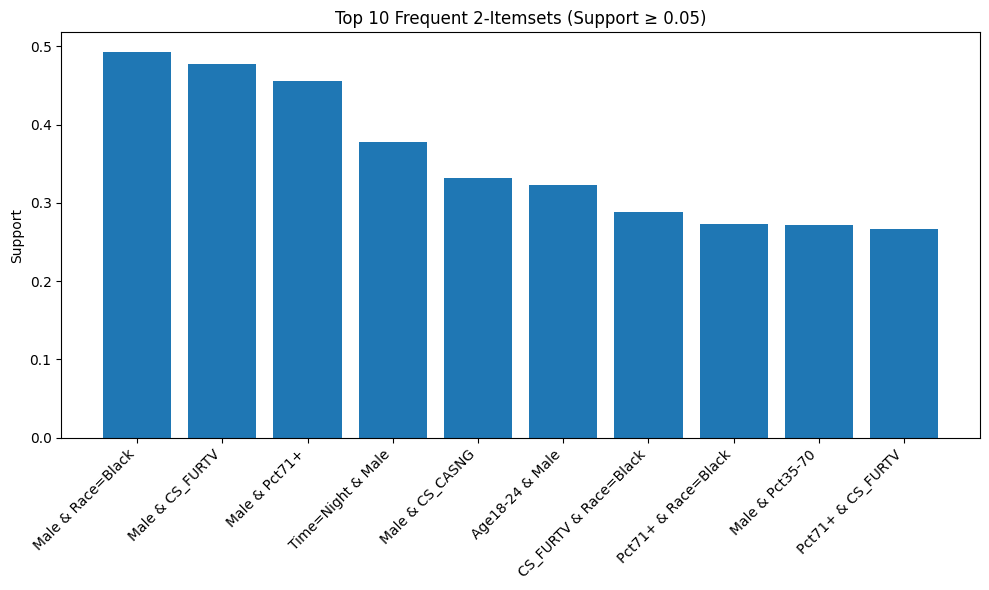

Top 10 Association Rules by Lift:


,antecedents,consequents,support,confidence,lift
106,"CS_LKOUT, Male, Pct71+",CS_CASNG,0.071610,0.725831,2.037350
109,"CS_LKOUT, Pct71+","CS_CASNG, Male",0.071610,0.672091,2.027022
94,"CS_LKOUT, Pct71+",CS_CASNG,0.076767,0.720487,2.022352
195,"CS_LKOUT, Male, Time=Night",CS_CASNG,0.050333,0.699664,1.963901
196,"CS_LKOUT, Time=Night","CS_CASNG, Male",0.050333,0.646322,1.949302
182,"CS_LKOUT, Time=Night",CS_CASNG,0.054063,0.694224,1.948633
44,"CS_LKOUT, Male",CS_CASNG,0.118532,0.680928,1.911313
152,"CS_LKOUT, Male, Race=Black",CS_CASNG,0.060832,0.677775,1.902463
154,"CS_LKOUT, Race=Black","CS_CASNG, Male",0.060832,0.630749,1.902336
36,CS_LKOUT,CS_CASNG,0.127539,0.675361,1.895686


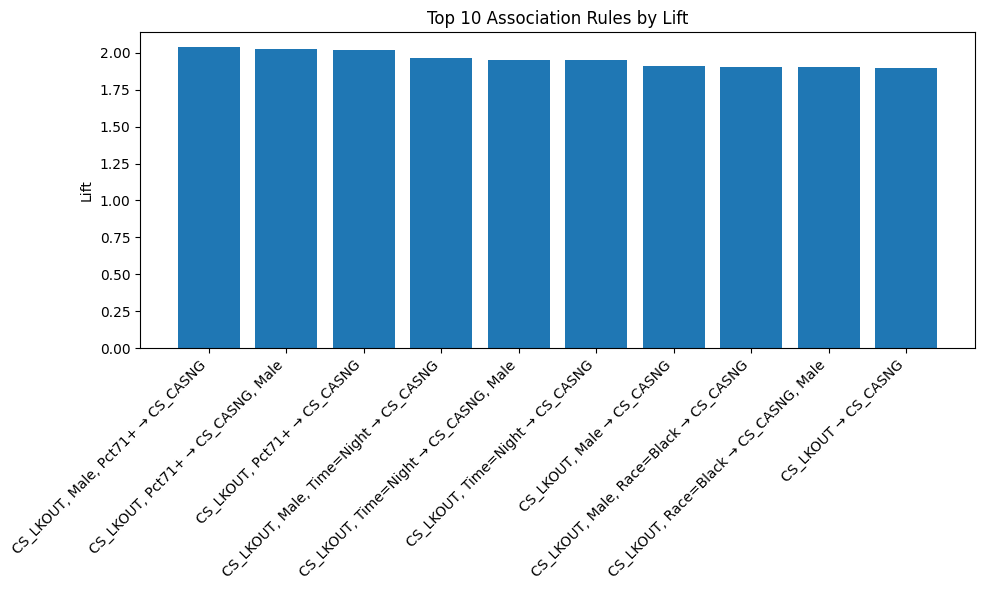

In [10]:
# -------------------------------------------------------------------
# 2.3 TABLES & VISUALIZATIONS
# -------------------------------------------------------------------

# ---- Table: Top 10 frequent 2-itemsets by support ----
top_2_itemsets = (
    frequent_itemsets[frequent_itemsets["length"] == 2]
    .nlargest(10, "support")
    .copy()
)

print("Top 10 frequent 2-itemsets:")
display(top_2_itemsets)

# ---- Plot: Top 10 frequent 2-itemsets ----
plt.figure(figsize=(10, 6))
labels = [' & '.join(list(i)) for i in top_2_itemsets['itemsets']]
plt.bar(range(len(top_2_itemsets)), top_2_itemsets['support'])
plt.xticks(range(len(top_2_itemsets)), labels, rotation=45, ha='right')
plt.ylabel("Support")
plt.title("Top 10 Frequent 2-Itemsets (Support ≥ {:.2f})".format(MIN_SUPPORT))
plt.tight_layout()
plt.show()

# ---- Table: Top 10 rules by lift ----
top_rules = rules.nlargest(10, "lift").copy()
# Clean up for display
top_rules_display = top_rules[[
    "antecedents", "consequents", "support", "confidence", "lift"
]].copy()

# Convert frozenset to readable strings
top_rules_display["antecedents"] = top_rules_display["antecedents"].apply(
    lambda x: ', '.join(sorted(list(x)))
)
top_rules_display["consequents"] = top_rules_display["consequents"].apply(
    lambda x: ', '.join(sorted(list(x)))
)

print("Top 10 Association Rules by Lift:")
display(top_rules_display)

# ---- Plot: Top 10 rules by lift ----
plt.figure(figsize=(10, 6))
rule_labels = [
    f"{a} → {c}"
    for a, c in zip(top_rules_display["antecedents"], top_rules_display["consequents"])
]
plt.bar(range(len(top_rules_display)), top_rules_display["lift"])
plt.xticks(range(len(top_rules_display)), rule_labels, rotation=45, ha='right')
plt.ylabel("Lift")
plt.title("Top 10 Association Rules by Lift")
plt.tight_layout()
plt.show()

In [11]:
# -------------------------------------------------------------------
# 3. EVALUATION: INTERESTING FINDINGS (PRINTED SUMMARY)
# -------------------------------------------------------------------

def describe_rule(row):
    return (f"Rule: {row['antecedents']} → {row['consequents']} | "
            f"support={row['support']:.3f}, "
            f"confidence={row['confidence']:.3f}, "
            f"lift={row['lift']:.2f}")

print("\n--- INTERESTING PATTERNS (EXAMPLES) ---")

# 1) Rules where CS_LKOUT implies CS_CASNG (if those columns exist)
mask_lkout_casng = (
    rules["antecedents"].apply(lambda s: "CS_LKOUT" in s) &
    rules["consequents"].apply(lambda s: "CS_CASNG" in s)
)
interesting_1 = rules[mask_lkout_casng].nlargest(5, "lift")

if not interesting_1.empty:
    print("\n[1] Lookout strongly associated with Casing:")
    for _, r in interesting_1.iterrows():
        print(" ", describe_rule(r))

# 2) Rules linking PF_HANDS to CS_FURTV
mask_hands_furtv = (
    rules["antecedents"].apply(lambda s: "PF_HANDS" in s) &
    rules["consequents"].apply(lambda s: "CS_FURTV" in s)
)
interesting_2 = rules[mask_hands_furtv].nlargest(5, "lift")

if not interesting_2.empty:
    print("\n[2] Use of hands associated with 'furtive movements':")
    for _, r in interesting_2.iterrows():
        print(" ", describe_rule(r))

# 3) Demographic concentration: rules where antecedent includes Race=Black or Age18-24
mask_demo = rules["antecedents"].apply(
    lambda s: ("Race=Black" in s) or ("Race=Hispanic" in s) or ("Age18-24" in s)
)
interesting_3 = rules[mask_demo].nlargest(5, "lift")

if not interesting_3.empty:
    print("\n[3] Patterns involving young males / racialized groups:")
    for _, r in interesting_3.iterrows():
        print(" ", describe_rule(r))

print("\n--- INTERPRETATION NOTES ---")
print("* High-confidence, high-lift rules involving CS_LKOUT → CS_CASNG suggest systematic co-coding of suspicion types.")
print("* Rules linking PF_HANDS (force) and CS_FURTV (furtive movements) highlight how subjective justifications co-occur with physical tactics.")
print("* Frequent itemsets and rules dominated by Male, Race=Black, Age18-24, and specific precinct buckets indicate concentrated policing patterns.")
print("* These are descriptive patterns, not causal proof; they should be interpreted alongside policy and legal context.")


--- INTERESTING PATTERNS (EXAMPLES) ---

[1] Lookout strongly associated with Casing:
  Rule: frozenset({'Male', 'Pct71+', 'CS_LKOUT'}) → frozenset({'CS_CASNG'}) | support=0.072, confidence=0.726, lift=2.04
  Rule: frozenset({'Pct71+', 'CS_LKOUT'}) → frozenset({'Male', 'CS_CASNG'}) | support=0.072, confidence=0.672, lift=2.03
  Rule: frozenset({'Pct71+', 'CS_LKOUT'}) → frozenset({'CS_CASNG'}) | support=0.077, confidence=0.720, lift=2.02
  Rule: frozenset({'Time=Night', 'CS_LKOUT', 'Male'}) → frozenset({'CS_CASNG'}) | support=0.050, confidence=0.700, lift=1.96
  Rule: frozenset({'Time=Night', 'CS_LKOUT'}) → frozenset({'Male', 'CS_CASNG'}) | support=0.050, confidence=0.646, lift=1.95

[2] Use of hands associated with 'furtive movements':
  Rule: frozenset({'Male', 'PF_HANDS'}) → frozenset({'CS_FURTV'}) | support=0.079, confidence=0.630, lift=1.22
  Rule: frozenset({'PF_HANDS'}) → frozenset({'CS_FURTV'}) | support=0.083, confidence=0.627, lift=1.22

[3] Patterns involving young males / r